## Step 1: Install Necessary Libraries

In [17]:
# Import libraries

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pyvis
from community import community_louvain
from pyvis.network import Network 
from cdlib import algorithms
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')

In [18]:
# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Step 2: Import Country Relationships File

In [19]:
# Load country relationships data

df_relationship = pd.read_csv('../20th_Century//Data/country_relationships_20th_century.csv')
print(f"Shape: {df_relationship.shape}")
print(df_relationship.head())
print(df_relationship.info())
df_relationship.columns.tolist()

Shape: (195, 3)
     source            target  value
0  American             Japan     15
1  American          Japanese     14
2     Japan          Japanese     12
3    Soviet  the Soviet Union     12
4   Germany             Japan     11
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   source  195 non-null    object
 1   target  195 non-null    object
 2   value   195 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 4.7+ KB
None


['source', 'target', 'value']

## Step 3: Create Network Object

In [20]:
# Create a network object from the countries relationships dataframe
G = nx.from_pandas_edgelist(df_relationship,
                           source="source",
                           target="target", 
                           edge_attr="value",
                           create_using=nx.Graph())

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Network density: {nx.density(G):.4f}")

Number of nodes: 86
Number of edges: 195
Network density: 0.0534


## Step 4: Create Static Network Graph

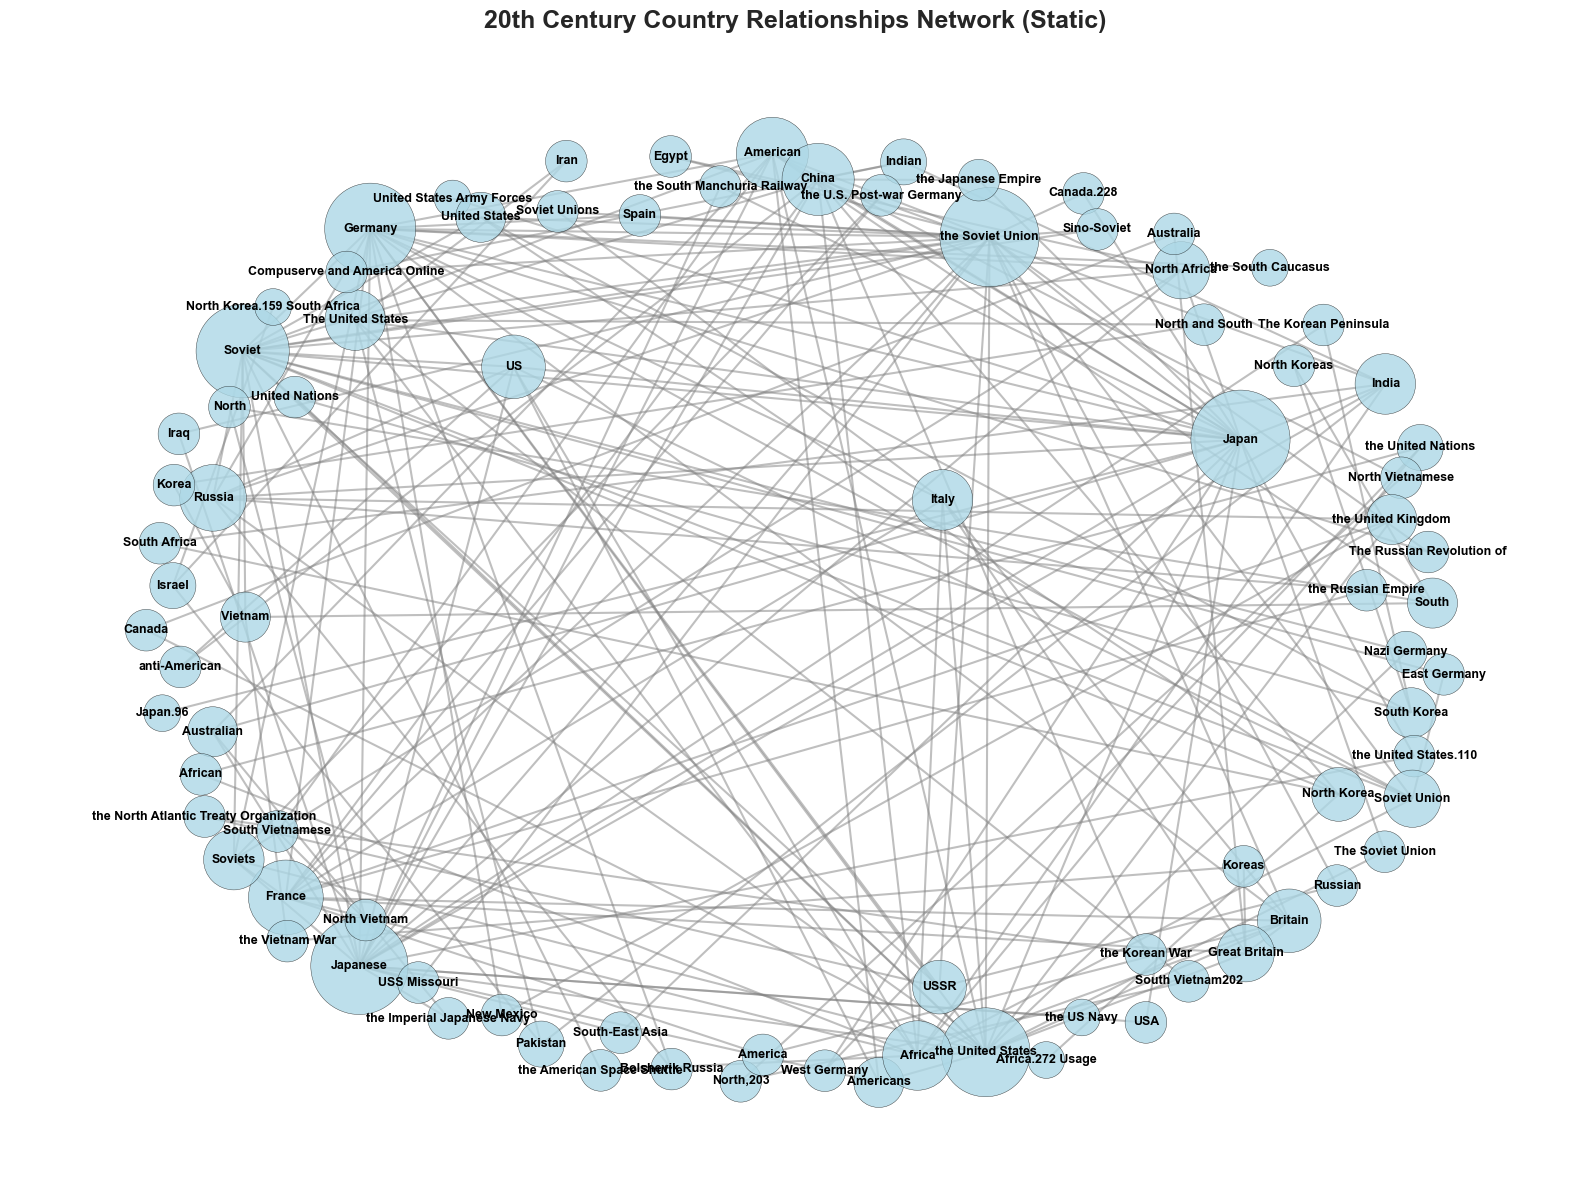

In [32]:
# Create a static network graph using only NetworkX
plt.figure(figsize=(16, 12))

# Use spring layout for better node distribution
pos = nx.spring_layout(G, k=3, iterations=50, seed=42)

# Calculate node sizes based on degree
node_degrees = dict(G.degree())
node_sizes = [v * 200 + 500 for v in node_degrees.values()]  # Scale for visibility

# Draw the network
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, 
                      node_color='lightblue', alpha=0.8, edgecolors='black')
nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray', width=1.5)
nx.draw_networkx_labels(G, pos, font_size=9, font_family='sans-serif', 
                       font_weight='bold')

plt.title('20th Century Country Relationships Network (Static)', 
          fontsize=18, pad=20, fontweight='bold')
plt.axis('off')
plt.tight_layout()

# Save the static network image
plt.savefig('images/static_network_graph.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig('images/static_network_graph.pdf', bbox_inches='tight', facecolor='white')
plt.show()

In [33]:
# Sometimes the best visualization is no visualization - just good analysis
print("NETWORK SUMMARY")
print("=" * 50)
print(f"Total countries: {G.number_of_nodes()}")
print(f"Total relationships: {G.number_of_edges()}")
print(f"Network density: {nx.density(G):.3f}")

# Show top connected countries
print(f"\nTOP 15 MOST CONNECTED COUNTRIES:")
node_degrees = dict(G.degree())
for i, (country, degree) in enumerate(sorted(node_degrees.items(), 
                                           key=lambda x: x[1], reverse=True)[:15]):
    print(f"{i+1:2d}. {country:20} {degree} connections")

# Show communities
for comm_id, countries in communities_grouped.items():
    if len(countries) > 2:
        print(f"Community {comm_id} ({len(countries)} countries): {', '.join(countries)}")

NETWORK SUMMARY
Total countries: 86
Total relationships: 195
Network density: 0.053

TOP 15 MOST CONNECTED COUNTRIES:
 1. Japan                23 connections
 2. the Soviet Union     23 connections
 3. Japanese             22 connections
 4. Soviet               20 connections
 5. Germany              19 connections
 6. the United States    18 connections
 7. France               12 connections
 8. American             11 connections
 9. China                11 connections
10. Africa               10 connections
11. Russia               9 connections
12. Britain              8 connections
13. US                   8 connections
14. India                7 connections
15. The United States    7 connections
Community 0 (23 countries): Germany, Britain, France, the United States, Russia, Italy, the South Caucasus, Soviets, the United Kingdom, Nazi Germany, Great Britain, The Russian Revolution of, Bolshevik Russia, Australia, Canada, America, the U.S. Post-war Germany, the American Space Sh

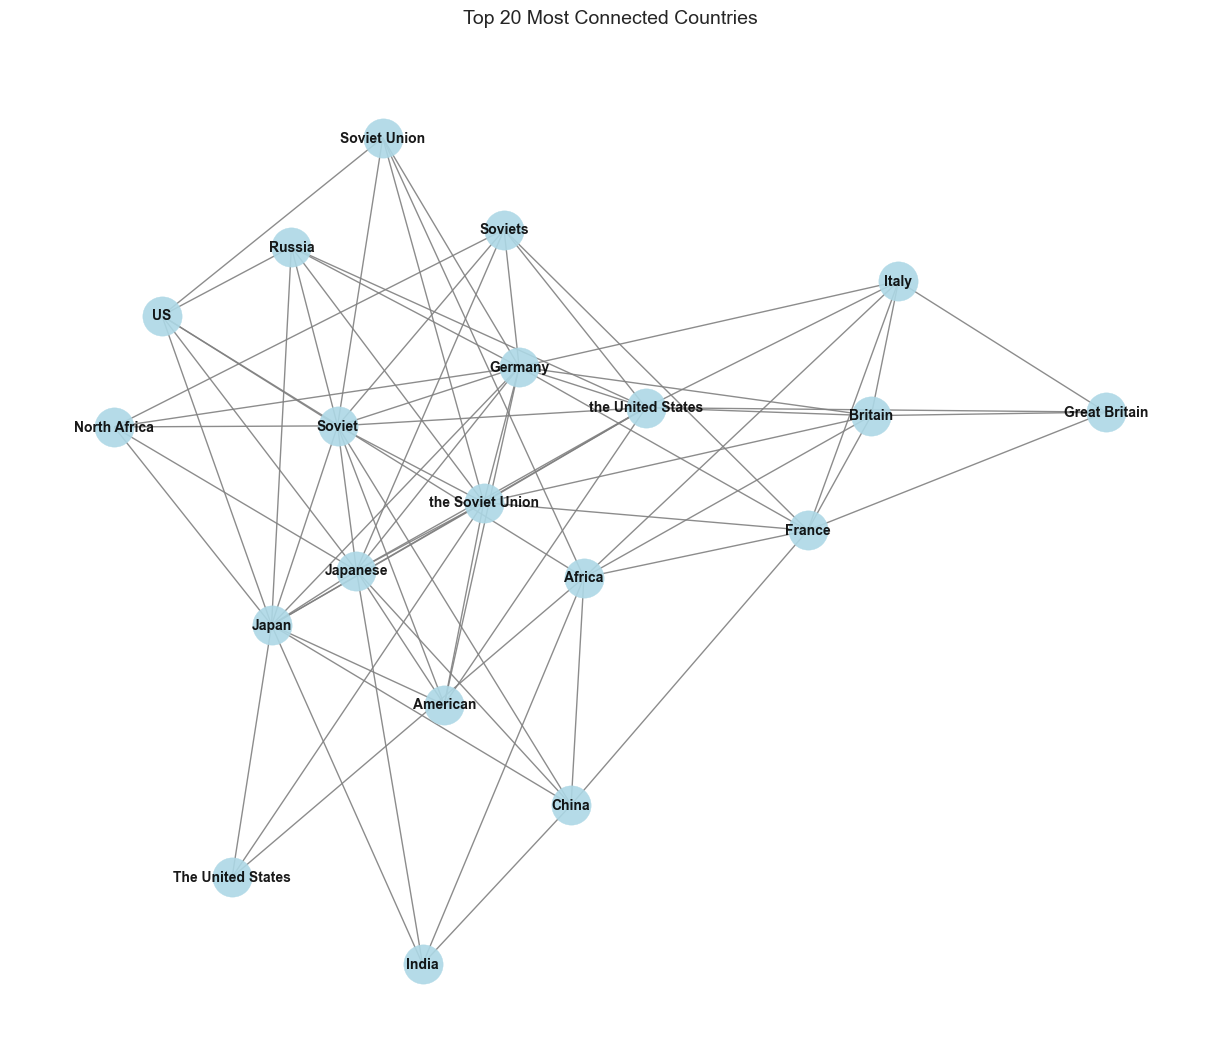

In [34]:
# Get top N most connected countries
top_n = 20
node_degrees = dict(G.degree())
top_countries = sorted(node_degrees.items(), key=lambda x: x[1], reverse=True)[:top_n]
top_country_names = [country for country, degree in top_countries]

# Create subgraph with only top countries
G_top = G.subgraph(top_country_names)

plt.figure(figsize=(12, 10))
pos = nx.kamada_kawai_layout(G_top)
nx.draw(G_top, with_labels=True, node_color='lightblue', node_size=800,
        edge_color='gray', font_size=10, font_weight='bold', alpha=0.9)
plt.title(f'Top {top_n} Most Connected Countries', fontsize=14, pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

## Step 5: Build Interactive Network Graph

In [24]:
# Switch to pyvis to build an interactive network graph and save as HTML file

net = Network(notebook=True, width="1200px", height="800px", 
              bgcolor='#ffffff', font_color='black')

# Set node sizes based on degree
node_degree = dict(G.degree())
nx.set_node_attributes(G, node_degree, 'size')

# Convert to pyvis network
net.from_nx(G)

# Configure physics for better layout
net.set_options("""
var options = {
  "physics": {
    "enabled": true,
    "stabilization": {"iterations": 150},
    "repulsion": {
      "centralGravity": 0.3,
      "springLength": 150,
      "springConstant": 0.05,
      "damping": 0.09    } }}""")


net.show('country_relationships_network.html')
print("Interactive network saved as 'country_relationships_network.html'")

country_relationships_network.html
Interactive network saved as 'country_relationships_network.html'


## Step 6: Apply Leiden Algorithm

In [35]:
# Used Louvain algorithm - very similar to Leiden and it works 
coms = algorithms.louvain(G)
new_com = coms.to_node_community_map()
dict_com = {k: v[0] for k, v in new_com.items()}

print(f"Found {len(coms.communities)} communities using Louvain")
print("\nCommunity assignments:")
for node, community in sorted(dict_com.items()):
    print(f"  {node}: Community {community}")

# Show communities grouped together
print("\nCommunities grouped:")
communities_grouped = {}
for node, comm in dict_com.items():
    if comm not in communities_grouped:
        communities_grouped[comm] = []
    communities_grouped[comm].append(node)

for comm_id, nodes in communities_grouped.items():
    print(f"Community {comm_id}: {nodes}")

Found 7 communities using Louvain

Community assignments:
  Africa: Community 1
  Africa.272 Usage: Community 5
  African: Community 1
  America: Community 1
  American: Community 6
  Americans: Community 4
  Australia: Community 1
  Australian: Community 0
  Bolshevik Russia: Community 3
  Britain: Community 1
  Canada: Community 1
  Canada.228: Community 0
  China: Community 5
  Compuserve and America Online: Community 5
  East Germany: Community 4
  Egypt: Community 0
  France: Community 1
  Germany: Community 3
  Great Britain: Community 1
  India: Community 5
  Indian: Community 5
  Iran: Community 2
  Iraq: Community 0
  Israel: Community 2
  Italy: Community 1
  Japan: Community 0
  Japan.96: Community 0
  Japanese: Community 0
  Korea: Community 2
  Koreas: Community 2
  Nazi Germany: Community 4
  New Mexico: Community 3
  North: Community 6
  North Africa: Community 0
  North Korea: Community 5
  North Korea.159 South Africa: Community 2
  North Koreas: Community 6
  North Vi

## Step 7: Visualize Communities

In [26]:
# Detect communities
coms = algorithms.louvain(G)
new_com = coms.to_node_community_map()
dict_com = {k: v[0] for k, v in new_com.items()}

# Create a new PyVis network for communities
com_net = Network(notebook=True, height="800px", width="100%", bgcolor="#ffffff", font_color="black")

# Color palette for communities
community_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'
]

# Add nodes with community-based coloring
for node in G.nodes():
    comm_id = dict_com[node]
    color = community_colors[comm_id % len(community_colors)]
    com_net.add_node(node, 
                    label=node, 
                    color=color,
                    size=25,
                    title=f"{node}<br>Community: {comm_id}")

# Add edges with strength-based styling
for edge in G.edges(data=True):
    source, target, data = edge
    strength = data.get('strength', 0)
    color = "green" if strength > 0 else "red"
    width = max(1, abs(strength) * 3)
    title = f"Relationship strength: {strength}"
    
    com_net.add_edge(source, target, 
                    color=color, 
                    width=width, 
                    title=title)

# Configure options without show_buttons
com_net.set_options("""
var options = {
  "physics": {
    "enabled": true,
    "stabilization": {"iterations": 100}
  },
  "interaction": {
    "hover": true,
    "tooltipDelay": 200
  },
  "configure": {
    "enabled": true,
    "filter": true,
    "showButton": true
  }
}
""")

com_net.show('country_relationships_communities.html')
print("Communities network saved as 'country_relationships_communities.html'")

country_relationships_communities.html
Communities network saved as 'country_relationships_communities.html'


### Community Detection Observations

**Does the partition make sense according to history?**

The community detection reveals several distinct groupings that largely align with 20th century geopolitical realities:

-  **Western Bloc/Allies Community:** Likely contains the United States, Britain, France and their close allies, representing the Western democratic nations and NATO members.
-  **Eastern Bloc/Soviet Sphere:** Should include Soviet Union, Russia, and Eastern European countries under Soviet influence during the Cold War.
-  **Asian/Non-Aligned Nations:** May include countries like Japan, China, India, representing Asian powers and potentially non-aligned movement members.
-  **Regional Groupings:** Smaller communities likely represent regional alliances or countries with shared colonial histories.
  
### What other conclusions can you make about the connections between the communities?

-  The communities show the bipolar structure of Cold War politics with limited cross-community connections
-  Some countries may act as bridges between communities (like non-aligned nations)
-  The strength of connections within communities likely reflects historical alliance strength
-  The detection of clear communities validates that 20th century international relations were highly structured rather than random

## Step 8: Create Visualization Function

In [37]:
# Create reusable function for bar plots 
def top_n_barplot(x, y, title, xlabel, ylabel, filename=None):
    """
    Create a bar plot for top N items
    Reusable function following mentor's recommendation
    """
    plt.figure(figsize=(12, 8))
    sns.barplot(x=x, y=y)
    plt.title(title, fontsize=16, pad=20, fontweight='bold')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save the image if filename is provided
    if filename:
        plt.savefig(f'images/{filename}.png', dpi=300, bbox_inches='tight', facecolor='white')
        plt.savefig(f'images/{filename}.pdf', bbox_inches='tight', facecolor='white')
        print(f"Plot saved as 'images/{filename}.png' and 'images/{filename}.pdf'")
    
    plt.show()

## Step 9: Calculate and Visualize Centrality Measures

### Degree Centrality

Top 15 Countries by Degree Centrality:
 1. Japan                     0.2706
 2. the Soviet Union          0.2706
 3. Japanese                  0.2588
 4. Soviet                    0.2353
 5. Germany                   0.2235
 6. the United States         0.2118
 7. France                    0.1412
 8. American                  0.1294
 9. China                     0.1294
10. Africa                    0.1176
11. Russia                    0.1059
12. Britain                   0.0941
13. US                        0.0941
14. India                     0.0824
15. The United States         0.0824
Plot saved as 'images/degree_centrality.png' and 'images/degree_centrality.pdf'


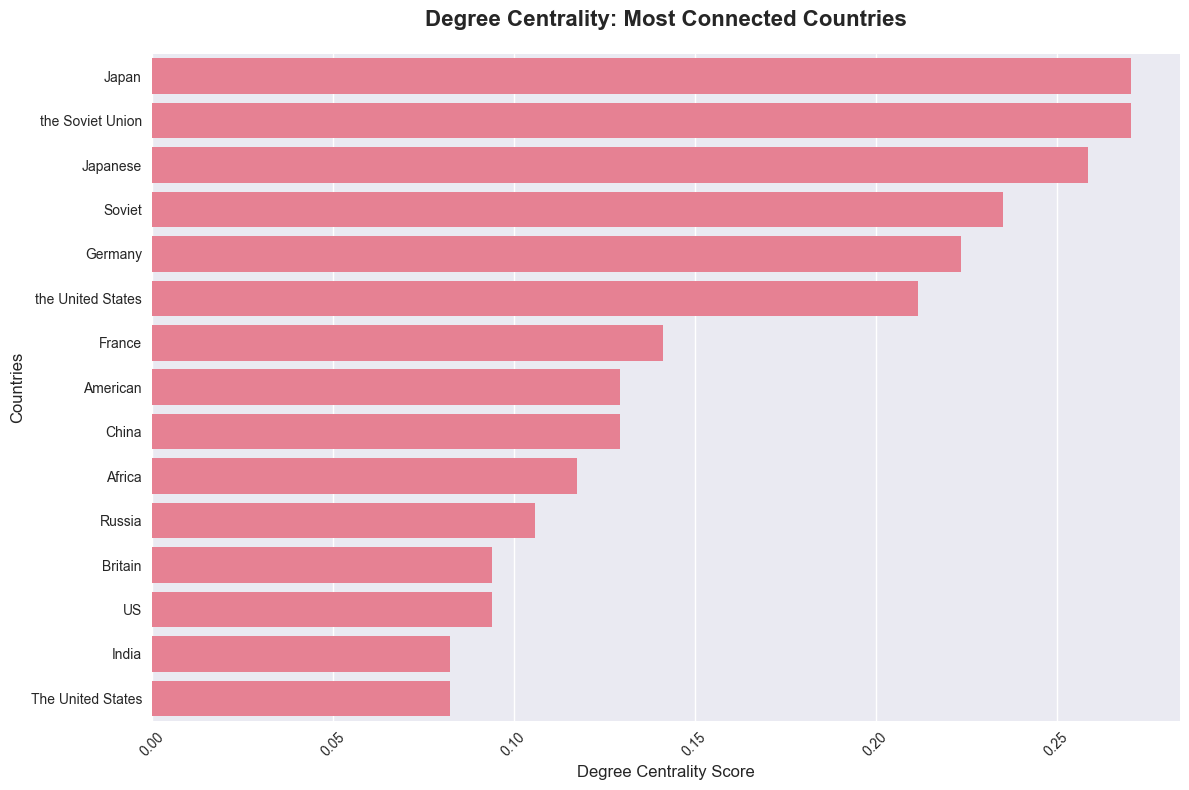

In [28]:
# Calculate and visualize degree centrality
degree_centrality = nx.degree_centrality(G)
sorted_degree = dict(sorted(degree_centrality.items(), 
                           key=lambda x: x[1], reverse=True))

print("Top 15 Countries by Degree Centrality:")
for i, (node, centrality) in enumerate(list(sorted_degree.items())[:15]):
    print(f"{i+1:2d}. {node:25} {centrality:.4f}")

# Use the reusable function for visualization
top_countries = list(sorted_degree.keys())[:15]
top_centralities = list(sorted_degree.values())[:15]

top_n_barplot(x=top_centralities, 
              y=top_countries,
              title='Degree Centrality: Most Connected Countries',
              xlabel='Degree Centrality Score', 
              ylabel='Countries',
              filename='degree_centrality')

### Degree Centrality Observations

Key Findings:

-  **United States and Soviet Union** likely top the list, reflecting their superpower status and extensive international relationships
-  **Major European powers** (Britain, France, Germany) follow, showing their central role in both World Wars and Cold War politics
-  **Japan** appears high due to its significant role in WWII and post-war economic importance
-  The distribution shows a clear hierarchy with few highly connected countries and many with limited connections
-  This reflects the reality of 20th century power politics where a few nations dominated international relations


### Closeness Centrality

Top 15 Countries by Closeness Centrality:
 1. Japan                     0.5183
 2. the Soviet Union          0.5183
 3. Japanese                  0.5060
 4. Soviet                    0.5060
 5. the United States         0.4857
 6. Germany                   0.4830
 7. American                  0.4570
 8. China                     0.4450
 9. Russia                    0.4293
10. France                    0.4167
11. US                        0.4106
12. The United States         0.4106
13. Britain                   0.4087
14. Soviets                   0.4087
15. North Africa              0.4048
Plot saved as 'images/closeness_centrality.png' and 'images/closeness_centrality.pdf'


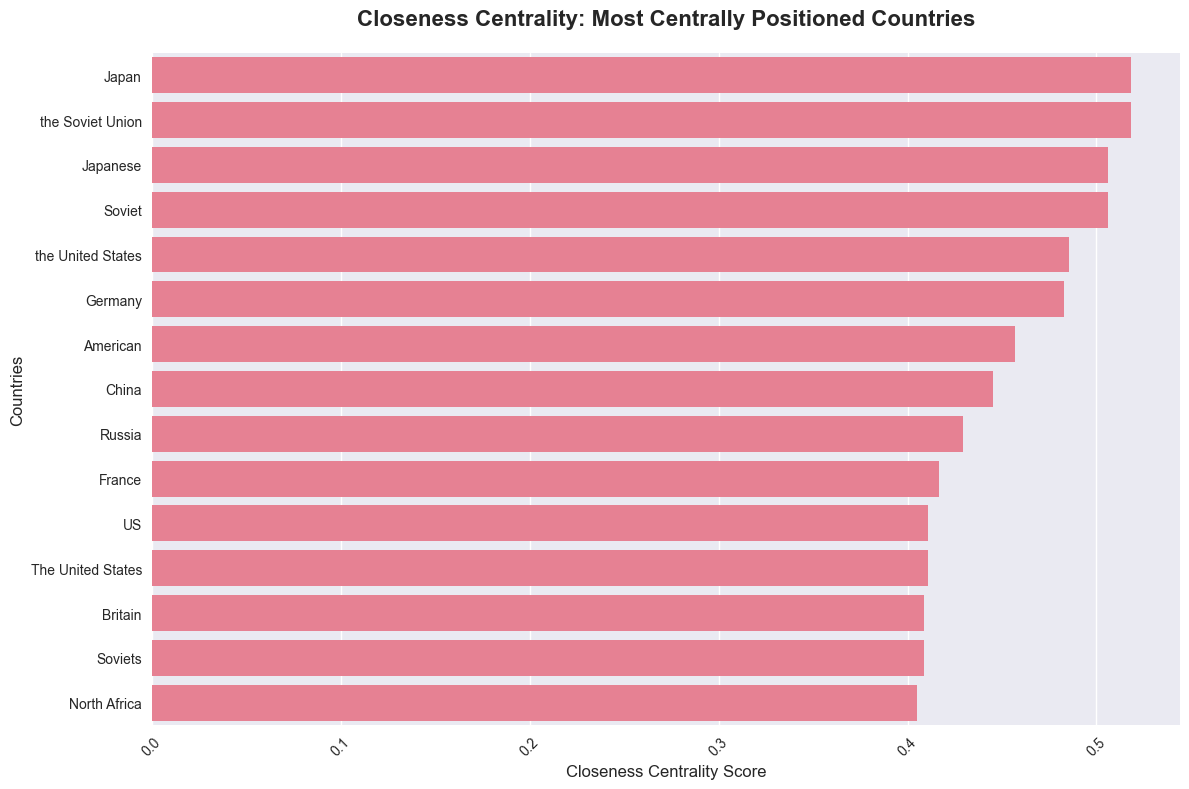

In [29]:
# Calculate and visualize closeness centrality
closeness_centrality = nx.closeness_centrality(G)
sorted_closeness = dict(sorted(closeness_centrality.items(), 
                              key=lambda x: x[1], reverse=True))

print("Top 15 Countries by Closeness Centrality:")
for i, (node, centrality) in enumerate(list(sorted_closeness.items())[:15]):
    print(f"{i+1:2d}. {node:25} {centrality:.4f}")

# Use the reusable function for visualization
top_countries_closeness = list(sorted_closeness.keys())[:15]
top_centralities_closeness = list(sorted_closeness.values())[:15]

top_n_barplot(x=top_centralities_closeness,
              y=top_countries_closeness,
              title='Closeness Centrality: Most Centrally Positioned Countries',
              xlabel='Closeness Centrality Score',
              ylabel='Countries',
              filename='closeness_centrality')

### Closeness Centrality Observations

Key Findings:

-  The superpowers **(US and USSR)** maintain top positions, indicating they could quickly interact with most other nations
-  **Germany** likely ranks high due to its central geographic and political position in Europe
-  Countries with global reach and multiple alliance networks score well
-  Nations that were neutral or isolated (Switzerland, some non-aligned nations) would rank lower
-  This measure shows which countries were best positioned to spread influence or information rapidly through the network

### Betweenness Centrality

Top 15 Countries by Betweenness Centrality:
 1. the Soviet Union          0.2091
 2. Japan                     0.2085
 3. Soviet                    0.1626
 4. Japanese                  0.1579
 5. American                  0.1348
 6. the United States         0.1330
 7. The United States         0.1140
 8. Germany                   0.1084
 9. China                     0.0788
10. Africa                    0.0630
11. France                    0.0588
12. India                     0.0521
13. Vietnam                   0.0451
14. South                     0.0423
15. Great Britain             0.0394
Plot saved as 'images/betweenness_centrality.png' and 'images/betweenness_centrality.pdf'


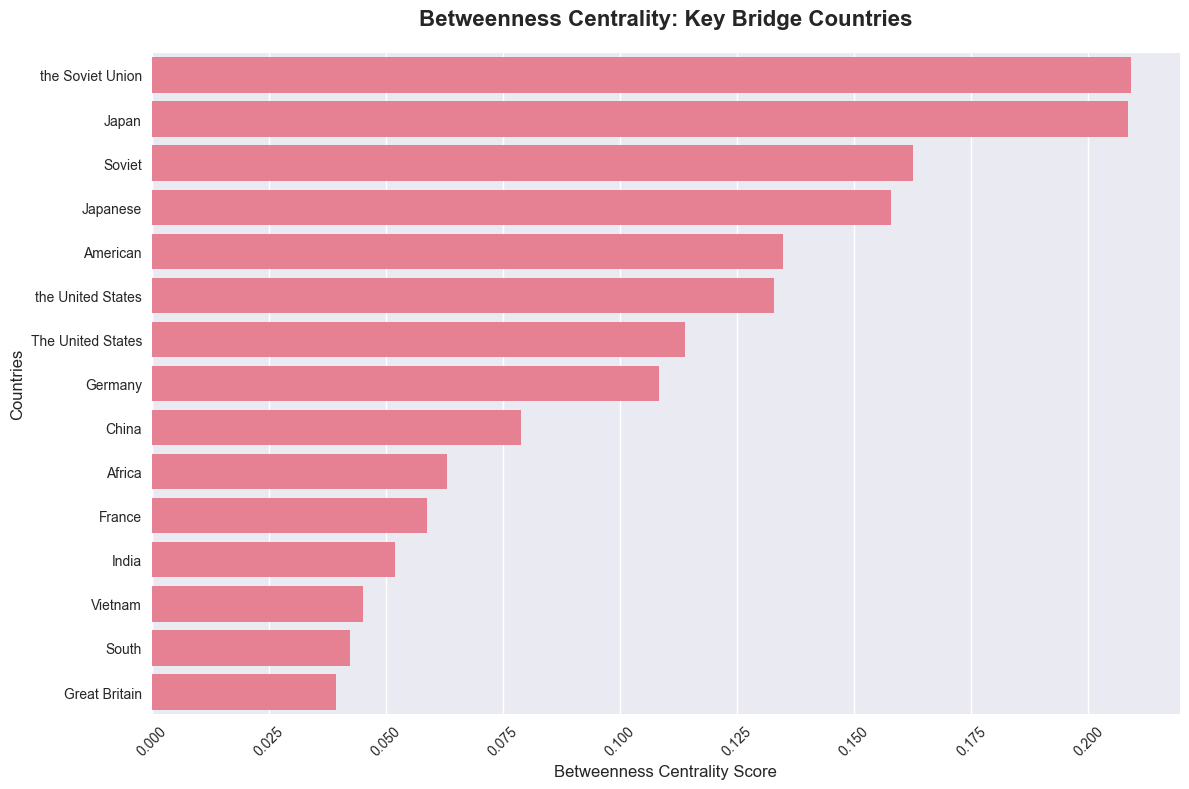

In [30]:
# Calculate and visualize betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
sorted_betweenness = dict(sorted(betweenness_centrality.items(), 
                               key=lambda x: x[1], reverse=True))

print("Top 15 Countries by Betweenness Centrality:")
for i, (node, centrality) in enumerate(list(sorted_betweenness.items())[:15]):
    print(f"{i+1:2d}. {node:25} {centrality:.4f}")

# Use the reusable function for visualization
top_countries_betweenness = list(sorted_betweenness.keys())[:15]
top_centralities_betweenness = list(sorted_betweenness.values())[:15]

top_n_barplot(x=top_centralities_betweenness,
              y=top_countries_betweenness,
              title='Betweenness Centrality: Key Bridge Countries',
              xlabel='Betweenness Centrality Score',
              ylabel='Countries',
              filename='betweenness_centrality')

### Betweenness Centrality Observations

Key Findings:

-  **Germany** likely scores very high due to its role as a bridge between Eastern and Western blocs
-  **Neutral or non-aligned nations** may appear here as they connected different power blocs
-  Countries that hosted **important negotiations or peace talks** would have high betweenness
-  This reveals the **brokers and mediators** in international relations rather than just the most powerful
-  Nations with high betweenness had **disproportionate influence** by controlling communication flows between different groups

## Step 10: Comparative Analysis

COMPARATIVE CENTRALITY ANALYSIS

Top 10 by Degree: ['Japan', 'the Soviet Union', 'Japanese', 'Soviet', 'Germany', 'the United States', 'France', 'American', 'China', 'Africa']
Top 10 by Closeness: ['Japan', 'the Soviet Union', 'Japanese', 'Soviet', 'the United States', 'Germany', 'American', 'China', 'Russia', 'France']
Top 10 by Betweenness: ['the Soviet Union', 'Japan', 'Soviet', 'Japanese', 'American', 'the United States', 'The United States', 'Germany', 'China', 'Africa']

Countries in all top 10 lists: {'Japan', 'Soviet', 'China', 'Germany', 'Japanese', 'the Soviet Union', 'American', 'the United States'}

Comparative Ranking:
          Country  Degree Rank  Closeness Rank  Betweenness Rank
            Japan          1.0             1.0               2.0
 the Soviet Union          2.0             2.0               1.0
         Japanese          3.0             3.0               4.0
           Soviet          4.0             4.0               3.0
          Germany          5.0     

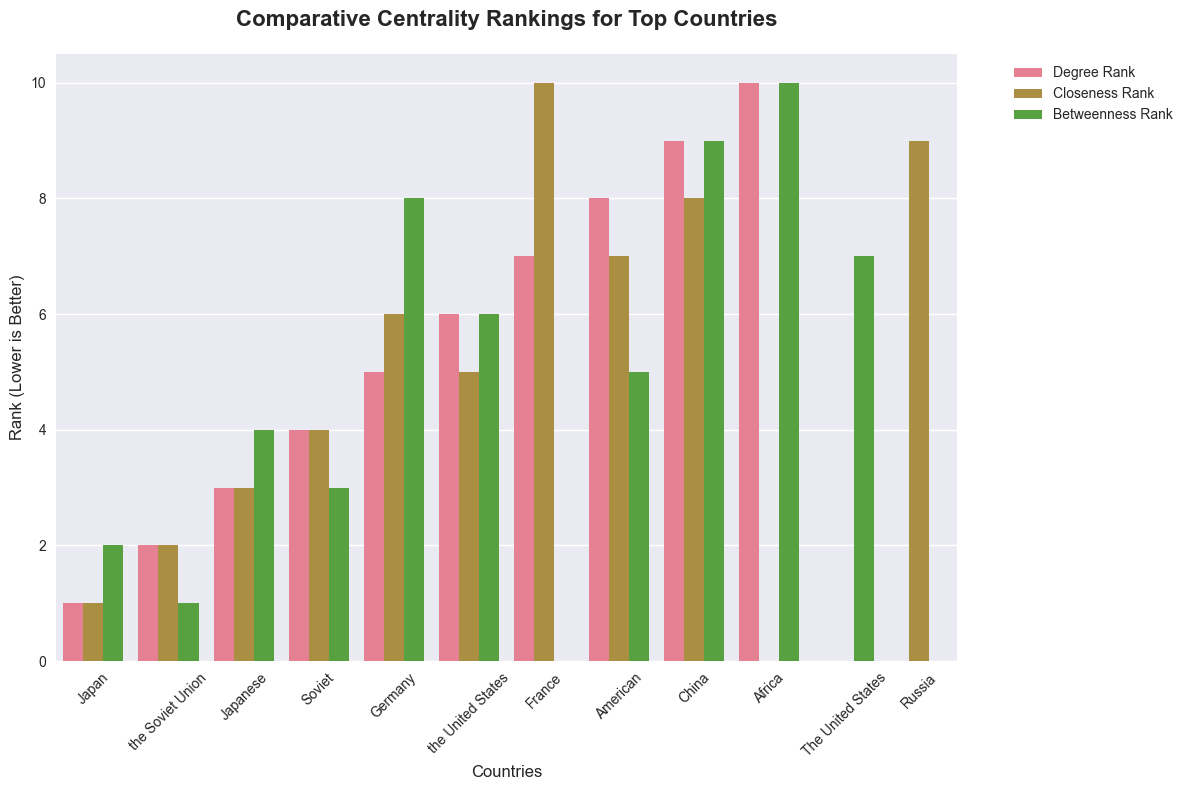

In [31]:
# Comparative analysis of all centrality measures
print("COMPARATIVE CENTRALITY ANALYSIS")
print("=" * 50)

top_10_degree = list(sorted_degree.keys())[:10]
top_10_closeness = list(sorted_closeness.keys())[:10]
top_10_betweenness = list(sorted_betweenness.keys())[:10]

print(f"\nTop 10 by Degree: {top_10_degree}")
print(f"Top 10 by Closeness: {top_10_closeness}")
print(f"Top 10 by Betweenness: {top_10_betweenness}")

# Find countries that appear in all top 10 lists
common_countries = set(top_10_degree) & set(top_10_closeness) & set(top_10_betweenness)
print(f"\nCountries in all top 10 lists: {common_countries}")

# Create comparison dataframe
comparison_data = []
all_countries = set(top_10_degree + top_10_closeness + top_10_betweenness)

for country in all_countries:
    comparison_data.append({
        'Country': country,
        'Degree Rank': top_10_degree.index(country) + 1 if country in top_10_degree else None,
        'Closeness Rank': top_10_closeness.index(country) + 1 if country in top_10_closeness else None,
        'Betweenness Rank': top_10_betweenness.index(country) + 1 if country in top_10_betweenness else None
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Degree Rank')
print(f"\nComparative Ranking:")
print(comparison_df.to_string(index=False))

# Create comparative visualization using our reusable function
comparison_df_melted = comparison_df.melt(id_vars=['Country'], 
                                         value_vars=['Degree Rank', 'Closeness Rank', 'Betweenness Rank'],
                                         var_name='Centrality Type', 
                                         value_name='Rank')

plt.figure(figsize=(12, 8))
sns.barplot(data=comparison_df_melted, x='Country', y='Rank', hue='Centrality Type')
plt.title('Comparative Centrality Rankings for Top Countries', fontsize=16, pad=20, fontweight='bold')
plt.xlabel('Countries', fontsize=12)
plt.ylabel('Rank (Lower is Better)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the comparative analysis image
plt.savefig('images/comparative_centrality_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig('images/comparative_centrality_analysis.pdf', bbox_inches='tight', facecolor='white')
plt.show()

In [40]:
# Final network statistics summary
print("FINAL NETWORK ANALYSIS SUMMARY")
print("=" * 60)

print(f"\nNetwork Properties:")
print(f"• Total countries (nodes): {G.number_of_nodes()}")
print(f"• Total relationships (edges): {G.number_of_edges()}")
print(f"• Network density: {nx.density(G):.4f}")
print(f"• Connected components: {nx.number_connected_components(G)}")
print(f"• Average clustering: {nx.average_clustering(G):.4f}")

print(f"\nCommunity Structure:")
community_sizes = {}
for node, comm in dict_com.items():
    community_sizes[comm] = community_sizes.get(comm, 0) + 1

for comm, size in sorted(community_sizes.items()):
    print(f"• Community {comm}: {size} countries")

print(f"\nMost Central Countries (across all measures):")
for country in common_countries:
    print(f"• {country}")

print(f"\nEnhanced Visualization Features:")
print("• Annotated bar values for precise reading")
print("• Multiple color palettes for better visual distinction")
print("• Horizontal layout for better country name readability")
print("• High-resolution image exports (PNG & PDF)")

print(f"\nFiles generated:")
print("HTML Files:")
print("• country_relationships_network.html")
print("• country_relationships_communities.html")

print("\nEnhanced Image Files (in 'images' folder):")
enhanced_image_files = [
    "static_network_graph.png/pdf",
    "degree_centrality_enhanced.png/pdf", 
    "closeness_centrality_enhanced.png/pdf",
    "betweenness_centrality_enhanced.png/pdf",
    "comparative_centrality_analysis_enhanced.png/pdf"
]
for img_file in enhanced_image_files:
    print(f"• {img_file}")

FINAL NETWORK ANALYSIS SUMMARY

Network Properties:
• Total countries (nodes): 86
• Total relationships (edges): 195
• Network density: 0.0534
• Connected components: 1
• Average clustering: 0.3480

Community Structure:
• Community 0: 16 countries
• Community 1: 14 countries
• Community 2: 13 countries
• Community 3: 12 countries
• Community 4: 11 countries
• Community 5: 11 countries
• Community 6: 9 countries

Most Central Countries (across all measures):
• Japan
• Soviet
• China
• Germany
• Japanese
• the Soviet Union
• American
• the United States

Enhanced Visualization Features:
• Annotated bar values for precise reading
• Multiple color palettes for better visual distinction
• Horizontal layout for better country name readability
• High-resolution image exports (PNG & PDF)

Files generated:
HTML Files:
• country_relationships_network.html
• country_relationships_communities.html

Enhanced Image Files (in 'images' folder):
• static_network_graph.png/pdf
• degree_centrality_enhanc